This notebook demonstrates how to use a common method found in the literature of airfoil optimization, parametric optimization. 
To this end we try gradient-based as well as gradient-free methods from the scipy optimization toolbox and use virtual displacements to allow the rapid the evaluation of the different geometries.

Do not take this notebook as a best-practice notebook for gradient-based optimization - unless you for some reason need or prefer the constraint of a PARSEC parameter space.
With gradient based optimization, there are better ways to avoid the pitfalls of airfoil optimization [1] than to severely restrict the design space using parametrization, e.g. constraining the resulting geometry to avoid high curvature.

Here, we restrict the design space to a PARSEC [2] parametrization and only look for symmetric airfoils, which reduces the parameter space to 5 values. 
This is a problem that can be solved by gradient-free optimizers as well as by gradient based solvers, even with the aid of finite-differences, without testing my patience too much.
We compare (analytical) gradient based optimization with a gradient-free optimizer, and subsequently build the Pareto-front of area against drag coefficient for different airfoil areas.
That is we have two goals (drag and area) and we find the subspace of parameters for which we cannot improve drag without decreasing area.

There are a lot of cases in the literature that are concerned with the PARSEC parameterization and optimizing airfoils.
For example, in [4] the PARSEC parametrization is used together with XFOIL [5] to find optima under different constraints and weights using heuristic search methods. 
For other, similar works see the references therein. 

In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "1"
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import numpy as np
from numpy import pi
import matplotlib
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.ERROR)

In [2]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 6]

In [3]:
# The code to generate parsec airfoils has been copied from 
#     https://github.com/dqsis/parsec-airfoils 
# by Dimitrios Kiousis. The code is part of the git repository of this notebook.
from parsec import parsec_airfoil

# Sample coefficients (NACA0012)
# The parameters are from [3]
rle = .015
x_pre = 0.29663
y_pre = -0.06002
d2ydx2_pre = 0.45150
th_pre = 10*pi/180
x_suc = 0.29663
y_suc = 0.06002
d2ydx2_suc = -0.45150
th_suc = -10*pi/180
yte = .0
N = 160
param = np.asarray([rle,x_pre,y_pre,d2ydx2_pre,th_pre,x_suc,y_suc,d2ydx2_suc,th_suc])

Base = parsec_airfoil(N,yte, rle,
                   x_pre, y_pre, d2ydx2_pre, th_pre,
                  x_suc, y_suc, d2ydx2_suc, th_suc)
BaseAirfoil = vft.repanel(Base[:,::-1],N,LEFAC=4)

We not only need the PARSEC parameter definition of an airfoil but also the gradients of all quantities of interest with respect to the parameter.
Viiflow returns the paraemters with respect to the virtual displacements, that is the shift of the geometry normal to its current surface at every discretization point.
To calculate the gradient with respect to the PARSEC parameters, we use the viiflowtools function `virtual_displacement_from_geometry(Base,Target)`, which calculates the displacement given a desired shape (Base) from a given shape (Target).
The gradient is then given by finite differences of this function.

For symmetric airfoils, the parameters needed are reduced to 5.

In [4]:
# Build airfoil from parameters and, if needed, calculate finite difference gradient of displacement-from-parameters
def dDeltadParam(param,N,BaseAirfoil,calc_gradient):
    tol = 1e-4
    scale = np.asarray([0.01,0.5,0.05,0.5,1,0.5,0.05,0.5,1])
    Airfoil0 = parsec_airfoil(N,0,*param)[:,::-1]
    [delta0,Shape] = vft.virtual_displacement_from_geometry(BaseAirfoil,Airfoil0)
    # Smooth a bit
    delta = delta0.copy()
    N = len(delta)
    delta[1:N-1] = 1/3*(delta0[0:N-2]+delta0[1:N-1]+delta0[2:N])
    if calc_gradient:
        dDeltadparam = np.zeros((BaseAirfoil.shape[1],9))
        for k in range(9):
            for s in [-1,1]:
                dparam = param.copy()
                dparam[k]+=s*tol*scale[k]
                Airfoil1 = parsec_airfoil(N,0,*dparam)[:,::-1]
                [delta01,_] = vft.virtual_displacement_from_geometry(BaseAirfoil,Airfoil1)
                delta1 = delta01.copy()
                delta1[1:N-1] = 1/3*(delta01[0:N-2]+delta01[1:N-1]+delta01[2:N])
                dDeltadparam[:,k] += 0.5*s*(delta1-delta)/tol/scale[k]
        return [delta,dDeltadparam,Shape,Airfoil0]
    else:
        return [delta,None,Shape,Airfoil0]

# For symmetric airfoils
def dDeltadParamSymmetric(paramSym,N,BaseAirfoil,calc_gradient):
    param = np.r_[paramSym,paramSym[1],-paramSym[2],-paramSym[3],-paramSym[4]]
    [delta,dDeltadparam,Shape,Airfoil0] = dDeltadParam(param,N,BaseAirfoil,calc_gradient)
    if calc_gradient:
        dParamdParamIn = np.r_[np.eye(5),np.c_[np.zeros((4,1)),np.diag([1,-1,-1,-1])]]
        dDeltadparam = dDeltadparam@dParamdParamIn
        return [delta,dDeltadparam,Shape,Airfoil0]
    else:
        return [delta,None,Shape,Airfoil0]
    
# This function calculates the cross-sectional area of an airfoil (polygon formula)
# We need that later in our optimization function
def AreaPoly(p,vd=None):
    BASE = np.asarray(p.foils[0].X)
    N = BASE.shape[1]
    X0 = BASE[0,:]
    Y0 = BASE[1,:]
    dX = np.asarray(p.foils[0].normals[0,:]).flatten()
    dY = np.asarray(p.foils[0].normals[1,:]).flatten()
    if not vd is None:
        XN = X0+vd*(dX)
        YN = Y0+vd*(dY)
    else:
        XN = X0
        YN = Y0
    Area = 0.5*np.dot((XN[1::]+XN[0:N-1]),(YN[1::]-YN[0:N-1]))
    Area_vd = np.zeros(N)
    Area_vd[1::] = 0.5*(dX[1::])*(YN[1::]-YN[0:N-1]) + 0.5*(dY[1::])*(XN[1::]+XN[0:N-1]) 
    Area_vd[0:N-1] += 0.5*(dX[0:N-1])*(YN[1::]-YN[0:N-1]) - 0.5*(dY[0:N-1])*(XN[1::]+XN[0:N-1]) 
    return (Area,Area_vd)

In the following section scipys optimization routines `SLSQP`(gradient based Newton-type method) and `Nelder-Mead`(Derivative-free method) are used to optimize the parameters for minimal drag for a symmetric airfoil.

In [5]:
from scipy import optimize

# Setup viiflow and solve NACA0012
# We re-use the viiflow object p and bl
setup = vf.setup(Re=1e6,Ma=0.0,Ncrit=9,Alpha=0,Gradients=True,Silent=True,Tolerance=1e-8)
(p,bl,x) = vf.init(BaseAirfoil,setup)
x,flag,res,grad,_ = vf.iter(x,bl,p,setup,None,None,None)
x0 = x

# This function is optimized
def evalFun(paramOpt,A0,calc_gradient,x0):
    global bl,p
    
    [delta,dDeltadparam,_,_] = dDeltadParamSymmetric(paramOpt,N,BaseAirfoil,calc_gradient)
    setup.Gradients = True
    x,flag,_,_,gradients = vf.iter(x0,bl,p,setup,None,None,delta)
    cd = bl[0].CD
    
    # Area
    areaWeight = 10
    A,A_vd = AreaPoly(p,delta)
    Adif = areaWeight*(A-A0)**2/A0
    Adif_vd = areaWeight*2*(A-A0)/A0*A_vd
    
    # If unconverged, let the optimizer know this is not a valid step
    if flag<=0:
        cd = np.inf
        (p,bl,_) = vf.init(BaseAirfoil,setup)
        x,flag,_,_,gradients = vf.iter(x0,bl,p,setup)
    grad = None
    gradA = None
    gradCD = None
    if calc_gradient:
        grad = np.asarray((gradients.total.cd_vd+Adif_vd)@dDeltadparam).ravel()
        gradA = (A_vd)@dDeltadparam
        gradCD = np.asarray((gradients.total.cd_vd)@dDeltadparam).ravel()

    # We don't really need all these outputs
    # But I did need them while debugging the different parts of our function or plotting
    return [cd+Adif, grad, cd, A, gradA,gradCD]

# This function is called in addition after a successful step
# Here we could also use plot callbacks
# Because I am not sure what "z" the scipy optimization routine evaluated last, and therefore what bl[0].CD contains,
# the drag is re-evaluated given the current iterate.
def iterfun(z,history,calc_gradient,x0):
    global lines,bl,p,fig,ax,cdmin
    [delta,_,Shape,_] = dDeltadParamSymmetric(z,N,BaseAirfoil,False)
    setup.Gradients = True
    x,flag,_,_,_ = vf.iter(x0,bl,p,setup,None,None,delta)
    if flag:
        history.append(bl[0].CD)
    
# Reduced parameter set and bounds on parameters
paramOpt = (param[0:5].copy())
bounds = [(0.001,0.1),(0.05,0.95),(-.5,-.0001),(0.01,2),(0,20*pi/180)]

# Solve and collect history of iterates
Area0,_ = AreaPoly(p)
cd0 = bl[0].CD
historyAnalytical = [cd0]
resultAnalytical = optimize.minimize(lambda z: evalFun(z,Area0,True,x0)[0:2], paramOpt, method='SLSQP', jac= True,options={"ftol":1e-13},bounds=bounds,callback=lambda z: iterfun(z,historyAnalytical,True,x0))
iterfun(resultAnalytical.x,historyAnalytical,True,x0)
print(resultAnalytical)
historyHeuristic = [cd0]
resultHeuristic = optimize.minimize(lambda z: evalFun(z,Area0,False,x0)[0], paramOpt, method='Nelder-Mead',options={"ftol":1e-9},bounds=bounds,callback=lambda z: iterfun(z,historyHeuristic,False,x0))
iterfun(resultHeuristic.x,historyHeuristic,False,x0)
print(resultHeuristic)

c:\users\maxra\scoop\apps\python\3.8.7\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


     fun: 0.004092069889150163
     jac: array([-1.30632762e-05, -2.69334340e-07, -8.51874932e-06, -8.27373367e-07,
        7.58504738e-07])
 message: 'Optimization terminated successfully'
    nfev: 64
     nit: 45
    njev: 45
  status: 0
 success: True
       x: array([ 0.01028949,  0.35125646, -0.05747909,  0.43458827,  0.2832449 ])
 final_simplex: (array([[ 0.01028424,  0.35134172, -0.05747994,  0.43466315,  0.28326771],
       [ 0.01027893,  0.35134071, -0.05748122,  0.43474864,  0.28325935],
       [ 0.01028391,  0.35127751, -0.05748047,  0.43467338,  0.28324291],
       [ 0.01027964,  0.35135322, -0.05748141,  0.43472363,  0.28324753],
       [ 0.01028418,  0.35130681, -0.0574806 ,  0.43463263,  0.28321969],
       [ 0.01028313,  0.35133949, -0.05748068,  0.43470961,  0.28329472]]), array([0.00409207, 0.00409207, 0.00409207, 0.00409207, 0.00409207,
       0.00409207]))
           fun: 0.004092069798810951
       message: 'Optimization terminated successfully.'
          nfev: 5

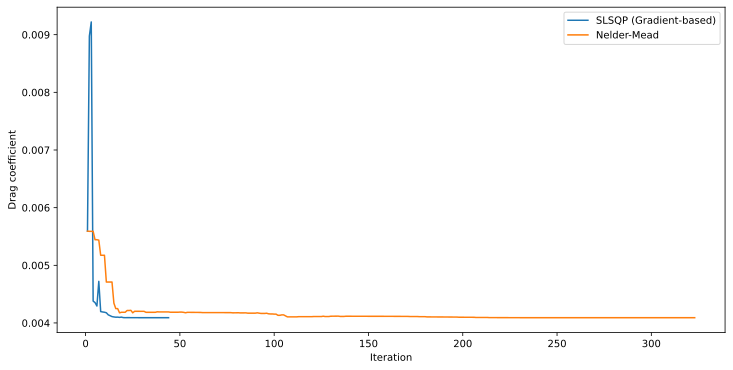

In [6]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(1,len(historyAnalytical)+1),historyAnalytical,label="SLSQP (Gradient-based)")
ax.plot(np.arange(1,len(historyHeuristic)+1),historyHeuristic,label="Nelder-Mead")
ax.legend()
ax.set_ylabel("Drag coefficient")
ax.set_xlabel("Iteration");

Both methods arrive at (very) similar optimization points.
However, the gradient-free method spend a lot more iterates and function evaluations arriving there.

In [7]:
# Run optimization over several Areas and Reynolds numbers
NSteps = 20
setup.Tolerance = 1e-6
setup.Itermax = 100
results = {}
for RE in [2e5,5e5,1e6]:
    setup.Re = RE
    Area0,_ = AreaPoly(p)
    AreaFac = np.r_[np.linspace(1,0.5,int(NSteps/2)),np.linspace(1,2,int(NSteps/2))]
    DragVector = np.zeros(NSteps)*np.nan
    AreaVector = np.zeros(NSteps)*np.nan
    XVector = np.zeros((5,NSteps))*np.nan

    for k in range(NSteps):
        if AreaFac[k]==1:
            print("init")
            (p,bl,x0) = vf.init(BaseAirfoil,setup)
            x0,_,_,_,gradients = vf.iter(x0,bl,p,setup)
            param0 = paramOpt;
        resultPareto = optimize.minimize(lambda z: evalFun(z,AreaFac[k]*Area0,True,x0)[0:2], 
                                             param0, method='SLSQP', jac= True,
                                             options={"ftol":1e-9,"maxiter":300},bounds=bounds
                                            )
        if resultPareto.status==0:
            [delta,_,_,_] = dDeltadParamSymmetric(resultPareto.x,N,BaseAirfoil,True)
            (p,bl,x) = vf.init(BaseAirfoil,setup)
            x0,flag,_,_,gradients = vf.iter(x0,bl,p,setup,None,None,delta)
            if flag:
                Area,_ = AreaPoly(p,delta)
                AreaVector[k] = Area
                DragVector[k] = bl[0].CD
                XVector[:,k] = resultPareto.x
                param0 = resultPareto.x
            else:
                (p,bl,x) = vf.init(BaseAirfoil,setup)
                x0,flag,_,_,gradients = vf.iter(x0,bl,p,setup)
    results[RE] = {}
    results[RE]["Area"]=AreaVector
    results[RE]["Drag"]=DragVector
    results[RE]["X"]=XVector
    

init


c:\users\maxra\scoop\apps\python\3.8.7\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


init
init
init
init
init


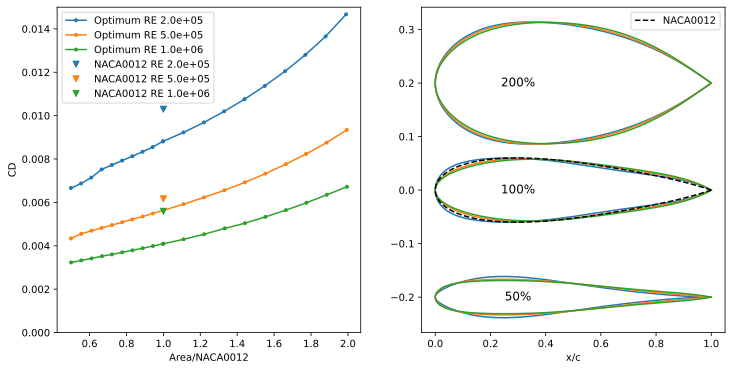

In [8]:
fig, ax = plt.subplots(1,2)
counter = 0
for RE in results.keys():
    order = np.argsort(results[RE]["Area"])
    ax[0].plot(results[RE]["Area"][order]/Area0,results[RE]["Drag"][order],'.-',label="Optimum RE %1.1e"%RE)
    ax[1].set_prop_cycle(None)
    for k in range(3):
        if k==0: # First non-nan
            index = 0
        elif k==1: # Closest to 1
            index = np.nanargmin(abs(results[RE]["Area"][order]/Area0-1.0))
        else: # Closest to 1.3
            index = np.nanargmin(abs(results[RE]["Area"][order]/Area0-2.0))
        [_,_,_,Shape] = dDeltadParamSymmetric(results[RE]["X"][:,order[index]],N,BaseAirfoil,False)
        ax[1].plot(Shape[0,:],Shape[1,:]+(k-1)*0.2,color = "C%u"%counter)

    counter+=1
    
ax[0].set_prop_cycle(None)
# Add simple NACA solution
for RE in results.keys():
    setup.Re = RE
    (p,bl,x) = vf.init(BaseAirfoil,setup)
    vf.iter(x,bl,p,setup)
    ax[0].plot(1.0,bl[0].CD,'v',label="NACA0012 RE %1.1e"%RE)
       
ax[1].text(.3, .2, '200%', fontsize = 12,ha='center', va='center')
ax[1].text(.3, 0, '100%', fontsize = 12,ha='center', va='center')
ax[1].text(.3, -.2, '50%', fontsize = 12,ha='center', va='center') 
ax[1].plot(BaseAirfoil[0,:],BaseAirfoil[1,:],'--k',label='NACA0012')

ax[0].set_ylim([0,0.015])
ax[0].set_xlabel('Area/NACA0012')
ax[0].set_ylabel('CD')
ax[1].set_xlabel('x/c')
ax[0].legend()
ax[1].legend()

The higher the Reynolds Number, the smaller the leading-edge radius and the more area is put aft - or the less "raindroppy" the airfoil becomes.
Interestingly, the improvement of drag from the starting airfoil is smallest at 5e5, where the NACA0012 seems to be close to the optimum shape for minimum drag at these settings.

[1] Drela, Mark. *Pros and cons of airfoil optimization.* Frontiers of computational fluid dynamics 1998 (1998): 363-381.

[2] Sobieczky, Helmut. *Parametric airfoils and wings.* Recent development of aerodynamic design methodologies. Vieweg+ Teubner Verlag, 1999. 71-87.

[3] Yu, J. C., and R. Wulandari. *Airfoil aerodynamics optimization under uncertain operating conditions.* Journal of Physics: Conference Series. Vol. 1446. No. 1. IOP Publishing, 2020.

[4] Della Vecchia, Pierluigi, Elia Daniele, and Egidio DʼAmato. *An airfoil shape optimization technique coupling PARSEC parameterization and evolutionary algorithm.* Aerospace Science and Technology 32.1 (2014): 103-110.

[5] Drela, Mark. *XFOIL: An analysis and design system for low Reynolds number airfoils.* Low Reynolds number aerodynamics. Springer, Berlin, Heidelberg, 1989. 1-12.